# Dataset analysis
To generate results for every dataset in the `dataset` folder, run:
```
for dataset in $(find dataset/* -maxdepth 0 -type d); do papermill dataset-info/DatasetBase.ipynb dataset-info/$(basename $dataset).ipynb -p input_dir $dataset; done
```

In [1]:
import matplotlib.pyplot as plt
import re, os
import papermill as pm
%matplotlib inline

In [2]:
# Parameters
input_dir = "dataset/caffe"


In [3]:
# Make a regex to extract dataset name
import re

matchObj = re.match( r'.*/(.*)', input_dir, re.M|re.I)
if matchObj:
    dataset_id = matchObj.group(1)
    dataset_id

In [4]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [5]:
# List files in input_dir in natural order
files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]
files = natural_sort(files)
files[0:5]

['dataset/caffe/2013_09_30_5b79183483036cbd1c9a5f1c583ae3ad50844254.csv',
 'dataset/caffe/2013_10_31_fb9968f0b513a318c1522c06a2085ba667db88c6.csv',
 'dataset/caffe/2013_11_28_eb38091b4e525e28cc6210985c8a2d189e7f91b7.csv',
 'dataset/caffe/2013_12_22_3213bd87ea70b5596b950f2fe200d5a06b90b00b.csv',
 'dataset/caffe/2014_01_31_3190ce709156a2b8c4bd79b50dd33b57a0ac874b.csv']

In [6]:
import pandas as pd
n_revisions = len(files)
dfs = [pd.read_csv(file) for file in files]

In [7]:
dfs[0].head()

,id,weight
0,c/gtest/gtest.h,19537
1,c/gtest/gtest-all.cpp,9118
2,c/caffe/vision_layers.hpp,350
3,c/caffe/util/math_functions.cpp,284
4,c/caffe/layers/conv_layer.cpp,245


In [8]:
from functools import reduce
# Outer join of files  
df_full = reduce((lambda x, y: pd.merge(x, y, how='outer', on='id')), dfs)

In [9]:
# Rename columns
df_full.columns = ['id'] + ['t'+str(i) for i in range(df_full.shape[1]-1)]

In [10]:
df_full.head()

,id,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t34,t35,t36,t37,t38,t39,t40,t41,t42,t43
0,c/gtest/gtest.h,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0,...,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0,19537.0
1,c/gtest/gtest-all.cpp,9118.0,9118.0,9118.0,9118.0,9118.0,9118.0,9118.0,9118.0,9118.0,...,9117.0,9117.0,9117.0,9117.0,9117.0,9117.0,9117.0,9117.0,9117.0,9117.0
2,c/caffe/vision_layers.hpp,350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c/caffe/util/math_functions.cpp,284.0,296.0,296.0,296.0,296.0,296.0,445.0,480.0,493.0,...,375.0,375.0,375.0,375.0,375.0,375.0,375.0,375.0,375.0,385.0
4,c/caffe/layers/conv_layer.cpp,245.0,254.0,254.0,254.0,254.0,167.0,168.0,168.0,168.0,...,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0


In [11]:
from collections import defaultdict
import networkx as nx

FILE_MARKER = '<files>'

def attach(branch, trunk):
    parts = branch.split('/', 1)
    if len(parts) == 1:  # branch is a file
        trunk[FILE_MARKER].append(parts[0])
    else:
        node, others = parts
        if node not in trunk:
            trunk[node] = defaultdict(dict, ((FILE_MARKER, []),))
        attach(others, trunk[node])

def build_adjacency_list(d, id, result):
    for key in d.keys():
        if key != FILE_MARKER:
            result.append((id, id + key))
            build_adjacency_list(d[key], id + key, result)
        else:
            for file in d[key]:
                result.append((id, id + file))

        
def plot_tree(id_list):
    
    keys = sorted(id_list)

    main_dict = defaultdict(dict, ((FILE_MARKER, []),))
    for line in keys:
        attach(line, main_dict)

    # _create adjacency list
    result = []
    build_adjacency_list(main_dict, "ROOT", result)

    G = nx.DiGraph()
    G.add_edges_from(result)
    # write dot file to use with graphviz
    # run "dot -_tpng test.dot >test.png"
    # nx.nx_agraph.write_dot(_g, 'test.dot')

    # same layout using matplotlib with no labels
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=False, arrows=False, node_size=2)



## Union tree of all revisions

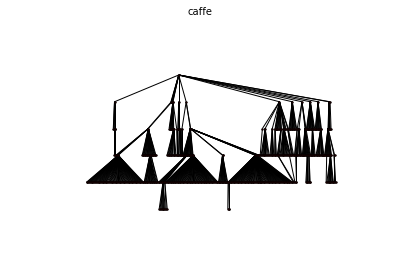

In [12]:
tree_fig = plt.figure(0)
tree_fig.suptitle(dataset_id)
plt.axis('off')
plot_tree(df_full['id'].tolist())
#pm.display('tree', tree_fig)



# Evolution

## Items count

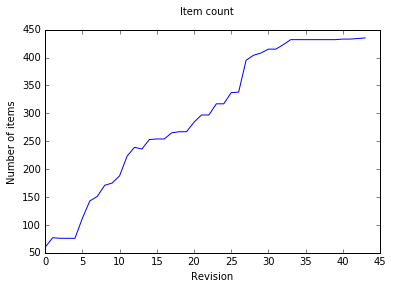

In [13]:
def plot_item_count():
    n_items = [len(df) for df in dfs]
    plt.plot(n_items)

fig = plt.figure()
fig.suptitle("Item count")
plt.ylabel('Number of items')
plt.xlabel('Revision')

plot_item_count()

## Weight count

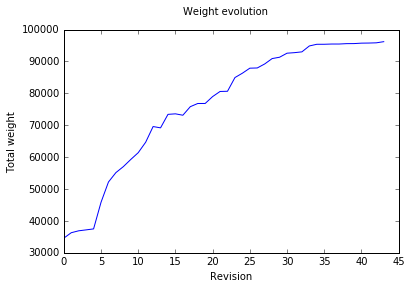

In [14]:
def plot_weight():
    total_weight = [sum(df['weight']) for df in dfs]
    plt.plot(total_weight)

fig = plt.figure()
fig.suptitle("Weight evolution")
plt.ylabel('Total weight')
plt.xlabel('Revision')
plot_weight()

## Addition and removal of items

In [15]:
# How to find removals
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="left_only"')

,id,weight_x,weight_y,_merge
2,c/caffe/vision_layers.hpp,350.0,NaN,left_only
13,c/caffe/optimization/solver.cpp,138.0,NaN,left_only
14,c/caffe/filler.hpp,150.0,NaN,left_only
23,c/caffe/layer.hpp,121.0,NaN,left_only
26,c/caffe/test/test_solver_mnist.cpp,108.0,NaN,left_only
30,c/caffe/layers/softmax_layer.cpp,91.0,NaN,left_only
31,c/caffe/util/math_functions.hpp,100.0,NaN,left_only
33,c/caffe/blob.hpp,73.0,NaN,left_only
35,c/caffe/test/test_solver_linear_regression.cpp,76.0,NaN,left_only
36,c/caffe/common.hpp,94.0,NaN,left_only


In [16]:
# How to find additions
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="right_only"')
# len(pd.merge...) to get the number of additions/deletions

,id,weight_x,weight_y,_merge
60,clude/caffe/vision_layers.hpp,NaN,426.0,right_only
61,c/caffe/solver.cpp,NaN,276.0,right_only
62,c/caffe/test/test_stochastic_pooing.cpp,NaN,162.0,right_only
63,clude/caffe/filler.hpp,NaN,147.0,right_only
64,clude/caffe/layer.hpp,NaN,136.0,right_only
65,amples/convert_cifar_data.cpp,NaN,110.0,right_only
66,amples/convert_mnist_data.cpp,NaN,106.0,right_only
67,kefile,NaN,111.0,right_only
68,clude/caffe/util/math_functions.hpp,NaN,106.0,right_only
69,clude/caffe/common.hpp,NaN,120.0,right_only


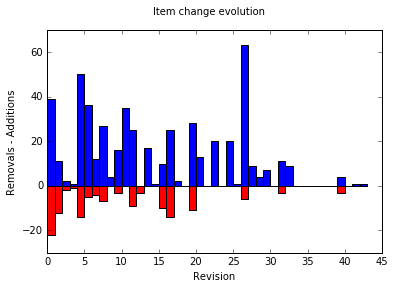

In [17]:
fig, ax = plt.subplots()

n_additions = []
n_removals = []
for i in range(1, n_revisions):
    n_additions.append(
        len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="right_only"')))
    n_removals.append(
        -len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="left_only"')))
x = range(0, n_revisions - 1)
ax.bar(x ,n_additions, width=1, color='b')
ax.bar(x, n_removals, width=1, color='r')

fig.suptitle("Item change evolution")
plt.ylabel('Removals - Additions')
plt.xlabel('Revision')



## Sum of cell's change in weight (stability)

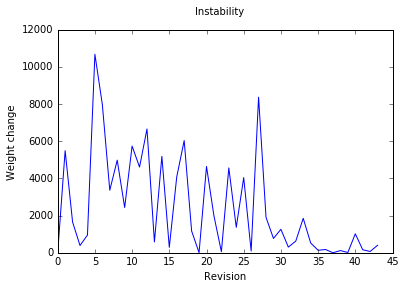

In [18]:
fig = plt.figure()
change = [0.0] * n_revisions
for index, row in df_full.fillna(0).iterrows():
    for j in range (2, len(row)):
        change[j-1] += abs(row[j] - row[j-1])

plt.plot(change)
fig.suptitle("Instability")
plt.ylabel('Weight change')
plt.xlabel('Revision')
    